<a href="https://colab.research.google.com/github/habibasherif12/OSCAR2017/blob/main/RNN_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import kagglehub
import os

# Download latest version
df_path = kagglehub.dataset_download("astandrik/yelp-review")

print("Path to dataset files:", df_path)



Path to dataset files: /root/.cache/kagglehub/datasets/astandrik/yelp-review/versions/1


In [11]:
# Find the CSV file within the downloaded directory
for filename in os.listdir(df_path):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(df_path, filename)
        break  # Stop searching once found

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path)


In [12]:

# Keep only necessary columns
df = df[['text', 'stars']]

# Convert ratings to binary sentiment (1-2 stars → Negative, 4-5 stars → Positive)
df = df[df['stars'] != 3]  # Remove neutral reviews
df['sentiment'] = df['stars'].apply(lambda x: 1 if x > 3 else 0)

sample_size = min(10000, len(df))
df = df.sample(sample_size, random_state=42)

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 6831, Testing samples: 1708


In [13]:
# Hyperparameters
MAX_VOCAB = 10000
MAX_LEN = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Padded sample: {X_train_pad[0]}")

Padded sample: [   4   56  296 1773  372    1    5   28   12   34   30   57  661    3
  896   45  133 1134    7  235  779   17  432   44    7  257  372   17
    9    5  386 1689   71   23   55    2  200   44   13   93  297 2147
    9   10   55    2   52    4    8 2028 3355   15   14 1446    3   24
    6 4941  335   88   91 2582   11    5 1188 1135    3    1   53  193
    1  766   15  319   17    9   55    2 2727   13 2234    2  142   53
   14  481    3    4  608   27    2 7766  284   10    8 1514   11    2
  670  161]


In [15]:
# Import necessary layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Embedding(MAX_VOCAB, 64, input_length=MAX_LEN),
    SimpleRNN(64, return_sequences=False, kernel_regularizer=L2(0.001)),
    Dense(1, activation='sigmoid')
])

# Compile model with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Callbacks for early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20, batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Save the trained model
model.save("simple_rnn_yelp_sentiment.h5")

print("Model training complete and saved as simple_rnn_yelp_sentiment.h5")


Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8043 - loss: 0.5649 - val_accuracy: 0.8009 - val_loss: 0.5387 - learning_rate: 5.0000e-04
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8024 - loss: 0.5105 - val_accuracy: 0.8004 - val_loss: 0.5315 - learning_rate: 5.0000e-04
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8435 - loss: 0.4283 - val_accuracy: 0.7787 - val_loss: 0.5622 - learning_rate: 5.0000e-04
Epoch 4/20
213/214 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9131 - loss: 0.2988
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9131 - loss: 0.2988 - val_accuracy: 0.7342 - val_loss: 0.6585 - learning_rate: 5.0000e-04
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9370 - loss: 0.2219 - val_accuracy: 0.7289 - val_loss: 0.6703 - learning_rate: 2.5000e-04


Model training complete and saved as simple_rnn_yelp_sentiment.h5


In [16]:
# Load the trained model
model = tf.keras.models.load_model("simple_rnn_yelp_sentiment.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8153 - loss: 0.5109
Test Loss: 0.5315
Test Accuracy: 0.8004


In [17]:
from sklearn.metrics import classification_report

# Predict sentiment on test data
y_pred_probs = model.predict(X_test_pad)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
print(classification_report(y_test, y_pred))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       340
           1       0.80      1.00      0.89      1368

    accuracy                           0.80      1708
   macro avg       0.57      0.50      0.45      1708
weighted avg       0.71      0.80      0.71      1708



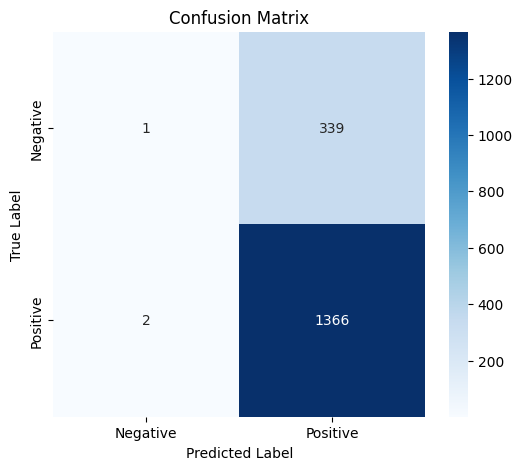

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()